# COMP41680 Assignment 2: Text Scraping and Classification

The objective of this assignment is to scrape a corpus of news articles from a set of
web pages, pre-process the corpus, and evaluate the performance of automated
classification of these articles in a supervised learning context.

<b><span style="color:blue">Name - Surojit Das<br>
Student ID - 17200072 </span></b>

Import packages

In [328]:
import os
import pandas as pd
import numpy as np
import urllib.request
import json
import bs4

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1. Data Collection

### Task 1 - Identifying URLs and category labels

To scrap the URLs, category and content of articles, parser called <u>BeautifulSoup</u> can be used.

In [333]:
home_url = "http://mlg.ucd.ie/modules/COMP41680/archive"

index = "index.html"

# Get the content of home webpage
content = urllib.request.urlopen(home_url + "/" + index)
parser = bs4.BeautifulSoup(content, "html.parser")

In [465]:
# Create an empty dictionary
url_with_months = dict()

# Scrap all urls along with their months
for match in parser.find_all("li"):
    url_with_months[match.a.text] = match.a.get('href')



Category label for each article has been scrapped in Task 2

### Task 2 - Retrieving all webpages from the URLs and extract main body.

First extract the category and the URLs of articles.

In [336]:
# Create an empty dictionary to store article
url_with_category = dict()

# Ignore below categories
ignore_categories = ['Article Category', 'N/A']

# Get the URLs of main atrticles and category name
for url_category in url_with_months.values():
    
    content2 = urllib.request.urlopen(home_url + "/" + url_category)
    parser2 = bs4.BeautifulSoup(content2, "html.parser")
    
    for match in parser2.find_all("tr"):
        
        # Get categories
        category_name = match.td.text
        category_name = category_name.strip()

        # Store categories along with their URLs
        if match.a != None and category_name not in ignore_categories:
            url_with_category[match.a.get('href')] = category_name


Now extract the article body and store the content along with their title. The idea is to scrap the title and body of all articles and store them in a single file. Each article will appear on each line of the file starting with the title.

<i>NOTE:</i> All articles web page have title mentioned twice. Below code will handle the duplication too. 

In [337]:
articles_file = "news-articles.txt"

# remove if articles_file already exists
if os.path.exists(articles_file):
    os.remove(articles_file)

# Extract main body of article and title
for link in list(url_with_category.keys()):

    article_content = urllib.request.urlopen(home_url + "/" + link)
    article_parser = bs4.BeautifulSoup(article_content, "html.parser")

    # Open the file
    f = open(articles_file, "a", encoding="utf-8")
    
    # Extract the body content using parser
    for result in article_parser.find_all('body'):
        
        # Capture title of the body
        article_title = result.h2.text
        article_title = article_title.strip()
        f.write(article_title) # Write the title to the file
        f.write(" ")
        
        # Capture unnecessary contents
        ignore_text = result.find("p",{'class':'notice'}).text
        ignore_text = ignore_text.strip()
        
        # Extract body of article
        for article_body in result.find_all('p'):
            
            # Remove empty values
            # Remove unnecessary contents
            # Remove duplicate title
            if len(article_body) > 0 and article_body.text != ignore_text and article_body.text != article_title:
                
                f.write(article_body.text) # Write the body to the file
                f.write(" ")
                
    f.write("\n")
    f.close()

### Task3 - Save the category labels for all articles in a separate file

In [338]:
# A separate file is created
label_file = "category_labels.txt"

# Remove the file if already exists
if os.path.exists(label_file):
    os.remove(label_file)

# Open the file
f2 = open(label_file, "a", encoding="utf-8")

# Add heading
f2.write("name,class")

# scrap the categories along with the URL to that file
for k_key in url_with_category:
    v_value = url_with_category[k_key]
    string = k_key + "," + v_value
    f2.write("\n")
    f2.write(string)
    
f2.close()

## Part 2. Text Classification

### Task1 - Load the set of raw documents and ensure that each document has a class label

In [286]:
# Open the news-articles file and store it's content
f_articles = open("news-articles.txt","r", encoding="utf-8")
raw_documents = f_articles.readlines()
f_articles.close()

# Create an empty list
article_content = []

# Read contents of news-article file line by line and append them into the list
for each_line in raw_documents:
    article_content.append(each_line)

# Now, read the category label file and store into a dataframe
df = pd.read_csv('category_labels.txt')

# This dataframe has only document name and class label
# So, create an additional column to add the contents for each document.
df['article'] = article_content
df.head(10)

,name,class,article
0,article-jan-0418.html,technology,21st-Century Sports: How Digital Technology Is...
1,article-jan-0027.html,business,Asian quake hits European shares Shares in Eur...
2,article-jan-0631.html,technology,BT offers free net phone calls BT is offering ...
3,article-jan-2105.html,business,Barclays shares up on merger talk Shares in UK...
4,article-jan-3300.html,sport,Barkley fit for match in Ireland England centr...
5,article-jan-4187.html,sport,Bellamy under new fire Newcastle boss Graeme S...
6,article-jan-1974.html,sport,Benitez 'to launch Morientes bid' Liverpool ma...
7,article-jan-3666.html,sport,Benitez delight after crucial win Liverpool ma...
8,article-jan-2629.html,technology,Big war games battle it out The arrival of new...
9,article-jan-2415.html,technology,British Library gets wireless net Visitors to ...


In [652]:
sample_doc = raw_documents[0]
# print a snippet
print(sample_doc[0:1000])

21st-Century Sports: How Digital Technology Is Changing the Face Of The Sporting Industry The sporting industry has come a long way since the ‘60s. It has carved out for itself a niche with its roots so deep that I cannot fathom the sports industry showing any sign of decline any time soon - or later. The reason can be found in this seemingly subtle difference - other industries have customers; the sporting industry has fans. Vivek Ranadivé, leader of the ownership group of the NBA’s Sacramento Kings, explained it beautifully, “Fans will paint their face purple, fans will evangelize. ... Every other CEO in every business is dying to be in our position — they’re dying to have fans.“ While fan passion alone could almost certainly keep the industry going, leagues and sporting franchises have decided not to rest on their laurels. The last few years have seen the steady introduction of technology into the world of sports - amplifying fans’ appreciation of games, enhancing athletes’ public p

### Task2 - create a document-term matrix, using appropriate text pre-processing and term weighting steps

Document-term matrix can be created from list of document string using Scikit-learn.

<b><i>Pre-processing steps</i></b><br><br>
Below are the steps which include the pre-processing of data.<br>
- Minimum term length: Exclude terms of length < 2. Scikit-learn does this by default.
- Case conversion: Converting all terms to lowercase. Scikit-learn does this by default.
- Stop-word filtering: Remove terms that appear on a pre-defined "blacklist" of terms that are highly frequent and do- not convey useful information.
- Low frequency filtering: Remove terms that appear in very few documents.
- Lemmatization: Reduce words to their base forms.

<i>NOTE</i>: Stemming can also be used instead of lemmatization. Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving the goal of reducing words to their roots correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. It is found that WordNet Lemmatisation is better in terms of conversion of words to their roots. Hence, stemming has been opted out.

To stem tokens to their base form, we need to use functionality from another third party library: <b>NLTK.</b>

In [343]:
import nltk
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Below function <i>lemma_tokenizer</i> is used for three purposes:
- Remove all punctuation from the raw text.
- Break the raw text into individual tokens because the documents are textual, not numeric.
- using wordNet lemmatizer, change the word tokens to their base form

In [344]:
# Define the function
def lemma_tokenizer(text):
    
    # Remove punctuation
    for punc in string.punctuation:
        text = text.replace(punc, "")
        
    # Use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    
    # Then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    
    for token in tokens:
        lemma_tokens.append(lemmatizer.lemmatize(token))
        
    return lemma_tokens

<b><i>Term Weighting steps</i></b><br><br>
We can improve the usefulness of the document-term matrix by giving more weight to the more "important" terms.<br>
The most common normalisation is term frequency–inverse document frequency (TF-IDF). In Scikit-learn, we can generate at TF-IDF weighted document-term matrix by using TfidfVectorizer().

In [345]:
# Lets put all pre-processing steps and term weighting steps together
vectorizer = TfidfVectorizer(stop_words="english",min_df = 5, tokenizer=lemma_tokenizer)
X = vectorizer.fit_transform(raw_documents)

print(X.shape)

# Create a dataframe
df_vectorized = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

# Display the document-term matrix
df_vectorized.head()

(1408, 6273)


,00,01,02,03,04,05,06,07,08,10,...,yuganskneftegas,yukos,zealand,zero,zidane,zinedine,zombie,zone,zoom,zurich
0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.05494,0.056639,0.057272,0.0,0.0,0.063288,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057947
2,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.029091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.040226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Attach the category labels to the document matrix

In [347]:
# Read the category_labels.txt file
read_labels = pd.read_csv("category_labels.txt")

# Check if "class_label" column already exists, if not create one and then add the categories to this column
if 'class_label' not in df_vectorized.columns:
    df_vectorized['class_label'] = read_labels['class']

# Check if "doc_name" column already exists, if not create one and then add name to this column and set it as index
if 'doc_name' not in df_vectorized.columns and df_vectorized.index.name != 'doc_name':
    df_vectorized['doc_name'] = read_labels['name']
    df_vectorized = df_vectorized.set_index('doc_name') # set index

# Display
df_vectorized.head(10)

,00,01,02,03,04,05,06,07,08,10,...,yukos,zealand,zero,zidane,zinedine,zombie,zone,zoom,zurich,class_label
doc_name,,,,,,,,,,,,,,,,,,,,,
article-jan-0418.html,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,technology
article-jan-0027.html,0.0,0.05494,0.056639,0.057272,0.0,0.0,0.063288,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.057947,business
article-jan-0631.html,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.029091,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,technology
article-jan-2105.html,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,business
article-jan-3300.html,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.040226,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,sport
article-jan-4187.html,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,sport
article-jan-1974.html,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,sport
article-jan-3666.html,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.039356,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,sport
article-jan-2629.html,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.052517,0.0,0.0,0.0,0.000000,0.0,0.000000,technology


We can check the count of each labels

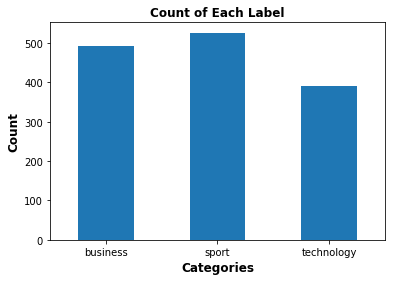

In [380]:
plt.figure()
df_vectorized.groupby('class_label').content.count().plot.bar(rot=0)
plt.title("Count of Each Label", fontweight='bold')
plt.xlabel("Categories", fontsize=12, fontweight='bold')
plt.ylabel("Count", fontsize=12, fontweight='bold')
plt.show()

### Task3 - Build two multi-class classification models using two different classifiers.

The goal of the classification tasks for this dataset is to check how accurate the classification models can predict the correct category labels ('technology', 'sport', 'business').

Get the data

In [350]:
# Put all data(except categories) from document-term matrix to X
X = df_vectorized.iloc[:, :-1]

# Put only the categories into Y
Y = df['class']

Prepare training and test dataset

In [351]:
# Splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, \
                                                    test_size = 0.3, \
                                                    random_state=0)

Training set can further be divided to validation set. This set can also be useful to check if the model is overfitting. However, we will <u>use</u> this validation set during evaluation only.

In [352]:
# splitting training data into train set and validation set
X_train_set, X_valid_set, y_train_set, y_valid_set = train_test_split(X_train, y_train, \
                                                                      test_size = 0.2, \
                                                                      random_state=0)

<b><i>Build multiclass classification models</i></b>

Let's take two different classifiers: <br>
- <i>K-Nearest Neighbours (KNN)</i> - The KNN algorithm uses the training examples as a basis for computing similarity. For a data record t to be classified, its k nearest neighbors are retrieved, and this forms a neighborhood of t. Majority voting among the data records in the neighborhood is used to decide the classification for t.<br><br>
- <i>Support Vector Machine (SVM)</i> - SVM is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data, the algorithm outputs an optimal hyperplane which categorizes new examples.

Import required packages

In [518]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Number of folds for cross-validation

In [447]:
cv_folds = 10

<b>1. KNN classification model </b>

In [621]:
# Train KNN classification model
clf_knn = KNeighborsClassifier(n_neighbors=3)

# Cross-validation on the model
score_knn = cross_val_score(clf_knn, X_train, y_train, cv=cv_folds)

print("Cross Validation Score: ", score_knn)
print("Averavge accuracy : ", sum(score_knn)/cv_folds)


Cross Validation Score:  [ 0.94        0.95        0.94        0.97979798  0.98989899  0.95959596
  0.93814433  0.97938144  0.96907216  0.96907216]
Averavge accuracy :  0.961496303239


Perform <b>GridSearch</b> to find out the best <i>hyper-parameters</i> for KNN

In [356]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_neighbors' : list(range(3, 24, 2))}] # Check for all odd possible values for nearest neighbour from 3 to 23

# Perform Grid Search
best_param_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose = 3)
best_param_knn.fit(X_train,y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.9396984924623115, total=   1.6s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] .......... n_neighbors=3, score=0.9543147208121827, total=   1.7s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s


[CV] .......... n_neighbors=3, score=0.9746192893401016, total=   1.7s
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.9591836734693877, total=   1.7s
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.9642857142857143, total=   1.6s
[CV] n_neighbors=5 ...................................................
[CV] ........... n_neighbors=5, score=0.964824120603015, total=   1.7s
[CV] n_neighbors=5 ...................................................
[CV] .......... n_neighbors=5, score=0.9644670050761421, total=   1.6s
[CV] n_neighbors=5 ...................................................
[CV] .......... n_neighbors=5, score=0.9746192893401016, total=   1.6s
[CV] n_neighbors=5 ...................................................
[CV] .......... n_neighbors=5, score=0.9591836734693877, total=   1.6s
[CV] n_neighbors=5 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  7.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

Find the best parameter

In [357]:
print("Best parameters set: ", best_param_knn.best_params_)
print("Best score:", best_param_knn.best_score_)

Best parameters set:  {'n_neighbors': 7}
Best score: 0.969543147208


It is clear that KNN has performed better with n_neighbors=7.<br>
Now do a cross-validation with best hyper-parameter, i.e., n_neighbors=7

In [622]:
tuned_knn = KNeighborsClassifier(n_neighbors=7)
tuned_knn.fit(X_train, y_train) # Fit the tuned KNN model

# Evaluate on the model
score_tuned_knn = cross_val_score(tuned_knn, X_train, y_train, cv=cv_folds)

print("Cross Validation Score: ", score_tuned_knn)
print("Averavge accuracy : ", sum(score_tuned_knn)/cv_folds)

Cross Validation Score:  [ 0.97        0.96        0.93        0.97979798  0.97979798  0.95959596
  0.94845361  0.97938144  0.97938144  0.97938144]
Averavge accuracy :  0.966578985734


<b>2. SVM Model classification</b>

In [623]:
clf_svc = SVC(C=1, gamma=0.1, kernel='rbf')

score_svc = cross_val_score(clf_svc, X_train, y_train, cv=cv_folds)

print("Cross Validation Score : ", score_svc)
print("Averavge accuracy : ", sum(score_svc)/cv_folds)

Cross Validation Score :  [ 0.95        0.98        0.96        0.97979798  0.96969697  0.98989899
  0.97938144  0.98969072  1.          0.96907216]
Averavge accuracy :  0.976753826929


Let's perform <b>GridSearch</b> to find out the best <i>hyper-parameters</i> for SVM

In [364]:
param_grid = [{'kernel': ('linear', 'rbf', 'poly'), \
               'C': [1, 10], 'gamma': [0.1, 1]
              }]

# Perform Grid Search
best_param_svm = GridSearchCV(SVC(), param_grid, cv=cv_folds, verbose = 3)
best_param_svm.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV]  C=1, gamma=0.1, kernel=linear, score=0.9899497487437185, total=   6.2s
[CV] C=1, gamma=0.1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV]  C=1, gamma=0.1, kernel=linear, score=0.9847715736040609, total=   6.7s
[CV] C=1, gamma=0.1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.1s remaining:    0.0s


[CV]  C=1, gamma=0.1, kernel=linear, score=0.9949238578680203, total=   6.8s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV]  C=1, gamma=0.1, kernel=linear, score=0.9846938775510204, total=   7.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV]  C=1, gamma=0.1, kernel=linear, score=0.9795918367346939, total=   7.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.964824120603015, total=   7.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.9695431472081218, total=   6.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.9746192893401016, total=   6.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.9846938775510204, total=   6.6s
[CV] C=1, gamma=0.1, kernel=rbf ................

[CV]  C=10, gamma=1, kernel=poly, score=0.8775510204081632, total=   7.8s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 11.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ('linear', 'rbf', 'poly'), 'C': [1, 10], 'gamma': [0.1, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

Find the best parameter set

In [365]:
print("Best parameters set: ", best_param_svm.best_params_)
print("Best score:", best_param_svm.best_score_)

Best parameters set:  {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Best score: 0.986802030457


Tune the model with best hyper-parameter found.

In [624]:
tuned_svm = SVC(C=1, gamma=0.1, kernel='linear')
tuned_svm.fit(X_train, y_train)

score_tuned_svm = cross_val_score(tuned_svm, X_train, y_train, cv=cv_folds)

print("Cross Validation Score : ", score_tuned_svm)
print("Averavge accuracy : ", sum(score_tuned_svm)/cv_folds)

Cross Validation Score :  [ 0.97        0.99        0.97        0.98989899  0.98989899  1.
  0.97938144  0.98969072  1.          0.96907216]
Averavge accuracy :  0.984794230969


### Task4. Predictions and Evaluation of two Models

<b><i>Prediction and evaluation</i></b>

Prediction, classification report and confusion matrix of tuned KNN Model on train set, valid set and test set

In [534]:
print("================== Training set =====================\n")
pred_train = tuned_knn.predict(X_train_set) # Prediction on training set
knn_train_acc = metrics.accuracy_score(y_train_set, pred_train) 
print("Accuracy: %s" %knn_train_acc + "\n")
print(metrics.classification_report(y_train_set, pred_train))

print("================== Validation set ===================\n")
pred_valid = tuned_knn.predict(X_valid_set) # Prediction on validation set
knn_valid_acc = metrics.accuracy_score(y_valid_set, pred_valid) 
print("Accuracy: %s" %knn_valid_acc + "\n")
print(metrics.classification_report(y_valid_set, pred_valid))

print("================== Test set =========================\n")
pred_knn=tuned_knn.predict(X_test) # Prediction on test set
acc_knn = metrics.accuracy_score(y_test, pred_test) 
print("Accuracy: %s" %acc_test + "\n")
print(metrics.classification_report(y_test, pred_knn))

print("================== Confusion Matrix =================")
display(pd.crosstab(y_test, pred_knn, rownames=['True'], colnames=['Predicted'], margins=True))

================== Training set =====================

Accuracy: 0.972081218274

             precision    recall  f1-score   support

   business       0.97      0.96      0.96       272
      sport       0.99      0.99      0.99       295
 technology       0.95      0.96      0.96       221

avg / total       0.97      0.97      0.97       788

================== Validation set ===================

Accuracy: 0.984771573604

             precision    recall  f1-score   support

   business       1.00      0.98      0.99        81
      sport       0.98      0.98      0.98        61
 technology       0.96      1.00      0.98        55

avg / total       0.99      0.98      0.98       197

================== Test set =========================

Accuracy: 0.964539007092

             precision    recall  f1-score   support

   business       0.97      0.95      0.96       138
      sport       0.98      0.96      0.97       170
 technology       0.94      0.98      0.96       115

avg / t

Predicted,business,sport,technology,All
True,,,,
business,131,2,5,138
sport,4,164,2,170
technology,0,2,113,115
All,135,168,120,423


Confusion Matrix heatmap

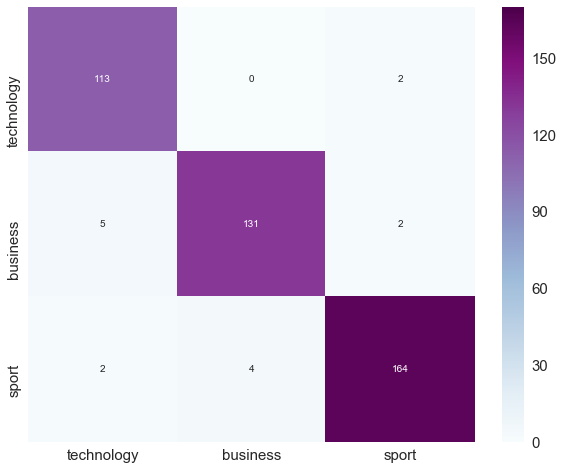

In [612]:
label_name = ["technology", "business", "sport"]

knn_cm = confusion_matrix(y_test, pred_knn, labels=label_name)
knn_cm_df = pd.DataFrame(knn_cm, label_name, label_name)

plt.figure(figsize=(10, 8))

sns.heatmap(knn_cm_df, annot=True, fmt="d", annot_kws={"size": 10}, vmin=0, vmax=170, cmap="BuPu")

Above KNNs label classification heatmap shows which label has been classified to which label. For example, 'sport' label has been classified correctly 164 times to 'sport' label, 4 times has been incorreclty classified to 'business' label and 2 times incorrectly classified to 'technology' label.

Prediction, classification report and confusion matrix of tuned SVM Model on train set, valid set and test set

In [541]:
print("================== Training set =====================\n")
pred_train = tuned_svm.predict(X_train_set) # Prediction on training set
svm_train_acc = metrics.accuracy_score(y_train_set, pred_train) 
print("Accuracy: %s" %svm_train_acc + "\n")
print(metrics.classification_report(y_train_set, pred_train))

print("================== Validation set ===================\n")
pred_valid = tuned_svm.predict(X_valid_set) # Prediction on validation set
svm_valid_acc = metrics.accuracy_score(y_valid_set, pred_valid) 
print("Accuracy: %s" %svm_valid_acc + "\n")
print(metrics.classification_report(y_valid_set, pred_valid))

print("================== Test set =========================\n")
pred_svm = tuned_svm.predict(X_test) # Prediction on test set
acc_svm = metrics.accuracy_score(y_test, pred_svm) 
print("Accuracy: %s" %acc_svm + "\n")
print(metrics.classification_report(y_test, pred_svm))

print("================== Confusion Matrix =================")
display(pd.crosstab(y_test, pred_svm, rownames=['True'], colnames=['Predicted'], margins=True))

================== Training set =====================

Accuracy: 0.998730964467

             precision    recall  f1-score   support

   business       1.00      1.00      1.00       272
      sport       1.00      1.00      1.00       295
 technology       1.00      1.00      1.00       221

avg / total       1.00      1.00      1.00       788

================== Validation set ===================

Accuracy: 1.0

             precision    recall  f1-score   support

   business       1.00      1.00      1.00        81
      sport       1.00      1.00      1.00        61
 technology       1.00      1.00      1.00        55

avg / total       1.00      1.00      1.00       197

================== Test set =========================

Accuracy: 0.981087470449

             precision    recall  f1-score   support

   business       0.98      0.99      0.98       138
      sport       0.98      0.98      0.98       170
 technology       0.98      0.97      0.98       115

avg / total       

Predicted,business,sport,technology,All
True,,,,
business,136,0,2,138
sport,3,167,0,170
technology,0,3,112,115
All,139,170,114,423


Confusion Matrix heatmap

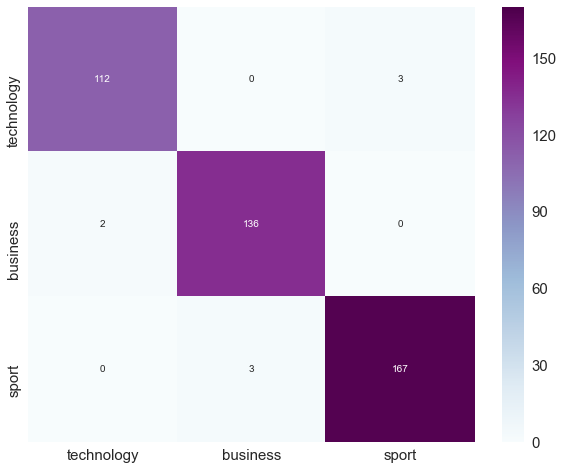

In [609]:
svm_cm = confusion_matrix(y_test, pred_svm, labels=label_name)
svm_cm_df = pd.DataFrame(svm_cm, label_name, label_name)

plt.figure(figsize=(10, 8))

sns.heatmap(svm_cm_df, annot=True, fmt="d", annot_kws={"size": 10}, vmin=0, vmax=170, cmap="BuPu")

Above SVMs label classification heatmap shows which label has been classified to which label. For example, 'sport' label has been classified correctly 167 times to 'sport' label, 3 times has been classified to 'business' label and never classified to 'technology' label.

<b><i>Accuracy comparison of two models</i></b>

Comparison on test dataset

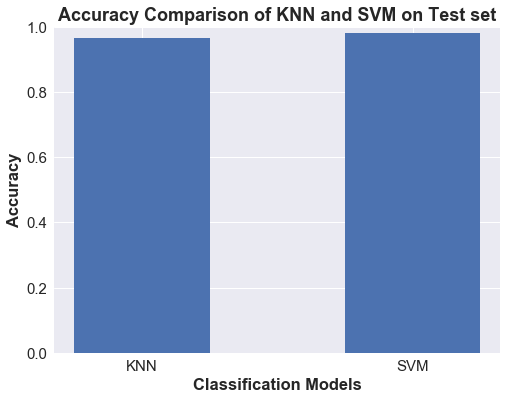

In [581]:
model_test_accuracy_comparisons = dict()

# Comparison between KNN and SVM accuracies
model_test_accuracy_comparisons["KNN"] = acc_knn
model_test_accuracy_comparisons["SVM"] = acc_svm

bar_width = 0.5

plt.figure(figsize=(8, 6))

# Plot the comparisons
plt.ylim(0, 1.0)
_ = plt.title("Accuracy Comparison of KNN and SVM on Test set", fontweight='bold')
_ = plt.bar(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center', width=bar_width)
_ = plt.xticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))
_ = plt.xlabel('Classification Models', fontweight='bold')
_ = plt.ylabel('Accuracy', fontweight='bold')


We can check how good a trained model is by testing the model on test data which is completely unseen by the model while learning. Above bar graph represents the accuracy of both models on test data. This bargraph clealy concludes that classification model of SVM has better accuracy in predicting the class lables on unseen data. 

<b><i>Comparison of tuned KNN and tuned SVM based on Precision, Recall and F1-score</i></b>

Calculating the accuracy of the model on test dataset is not enough. There are other classification measures that can be looked at as well to provide more insight about how accurate your model is. These classification measures are Precision, Recall and F1-score

<b>Precision</b> can be termed as proportion of retrieved results that are relevant, whereas Recall can be termed as proportion of relevant results that are retrieved. Precision is the number of correct results divided by number of all returned results. Precision can be thought of as a measure of a classifiers exactness. A high precision can indicate a low number of False Positives.

<b>Recall</b>, on the other hand, is the number of correct results divided by the number of results that should have been returned. Recall can be thought of as a measure of a classifiers completeness. A high recall indicates less False Negatives.

<b>F-measure</b> is the measure of test’s accuracy. It conveys the balance between the precision and the recall (f1-measure). F1 score reaches its best value at 1 and worst at 0. 

To calculate Precison, Recall and F1-score separate, we can use Scikit-Learn libray

In [275]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Create two empty lists
eval_score_knn = list()
eval_score_svm = list()

# Append precision, recall, f1-score of KNN to empty list
eval_score_knn.append(precision_score(y_test, pred_knn, average='weighted'))
eval_score_knn.append(recall_score(y_test, pred_knn, average='weighted'))
eval_score_knn.append(f1_score(y_test, pred_knn, average='weighted'))

# Append precision, recall, f1-score of SVM to empty list
eval_score_svm.append(precision_score(y_test, pred_svm, average='weighted'))
eval_score_svm.append(recall_score(y_test, pred_svm, average='weighted'))
eval_score_svm.append(f1_score(y_test, pred_svm, average='weighted'))

Plot the graph

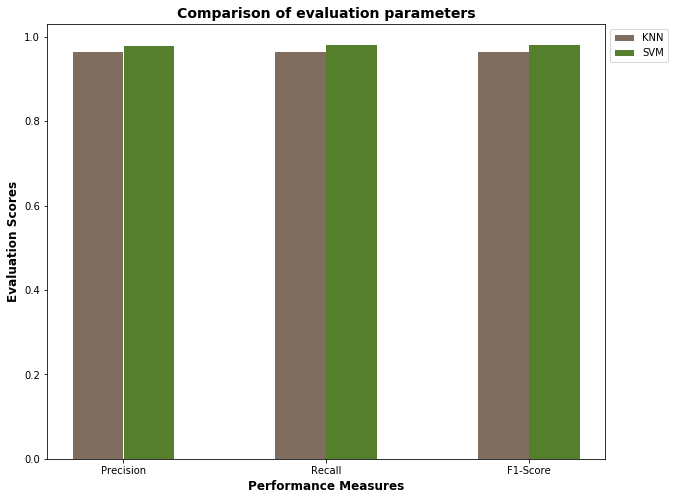

In [490]:
import matplotlib.pyplot as plt

# Setting bar width
bar_width = 0.25

# Setting postions of bars on x-axis
bar1 = np.arange(len(eval_score_knn))
bar2 = [x + bar_width for x in bar1]

plt.figure(figsize=(10, 8))

# Plot
plt.title("Comparison of evaluation parameters", fontweight='bold', fontsize=14)
plt.bar(bar1, eval_score_knn, color='#7f6d5f', width=bar_width, edgecolor='white', label='KNN')
plt.bar(bar2, eval_score_svm, color='#557f2d', width=bar_width, edgecolor='white', label='SVM')

# Add ylabel and xticks
plt.ylabel('Evaluation Scores', fontweight='bold', fontsize=12)
plt.xlabel('Performance Measures', fontweight='bold', fontsize=12)
plt.xticks([i + 0.125 for i in range(len(eval_score_knn))], ['Precision', 'Recall', 'F1-Score'])

plt.legend(bbox_to_anchor=(1, 1), loc=0)
plt.show()

From above barplot, we can conclude that SVM has better precision, recall and f1-score than KNN. High scores represent a good quality model. 

<b><i>Comparison of Cross-Validation scores</i></b>

One of the major problem of training a model is overfitting. Training a model with similar dataset builds a model to good at training set but may perform terrible on test dataset. The problem of overfitting can be reduced by doing a cross-validation of model on training dataset. Cross-validation invloves the concept of <u>K-fold cross validation</u>. K-Fold cross validation is an efficient method in training the model by taking a fraction of training dataset as a test set and check the learned model on that test set. This occurs for k times which eventually evaluate the whole training set and build a less overfitted model.

Thus, I have performed cross-validation before and after of tuning the model with best hyper-parameters. Cross-validation scores will be ideal to check if the models have improved.

Let's compare the cross-validation scores of KNN, Tuned KNN, SVM and Tuned SVM. Remember that the tuned classifiers are trained with best hyper-parameters of that particular classifiers.

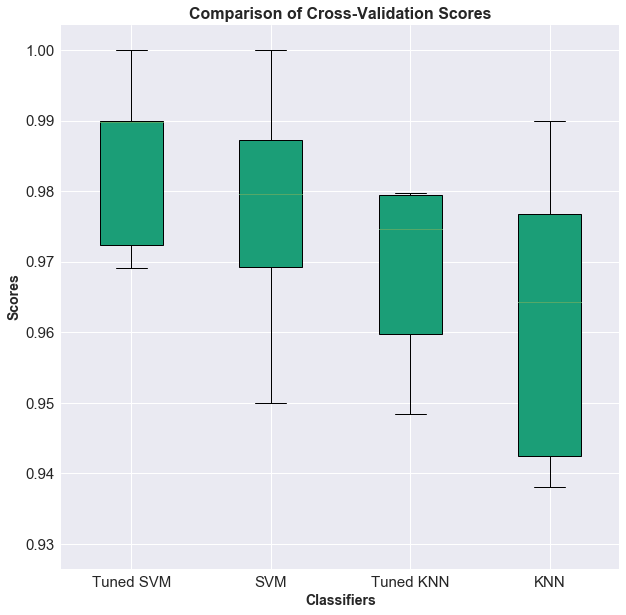

In [634]:
# Store all cross-validation score
cross_val_data = [score_tuned_svm, score_svc, score_tuned_knn, score_knn]

fig = plt.figure(1, figsize=(10, 10))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(cross_val_data, patch_artist=True)

ax.set_title("Comparison of Cross-Validation Scores", fontweight='bold', fontsize=16)
ax.set_ylabel("Scores", fontweight='bold', fontsize=14)
ax.set_xlabel("Classifiers", fontweight='bold', fontsize=14)

for box in bp['boxes']:
    # change fill color
    box.set(facecolor = '#1b9e77')

ax.set_xticklabels(['Tuned SVM', 'SVM', 'Tuned KNN', 'KNN'])

#Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

From above boxplot, we can conclude that cross-validation results of both KNN and SVM before and after tuning the model with gridsearch, the accuracies have been increased. The distribution of accuracies for KNN after tuning has been reduced remarkably. Similarly, SVM also has shown slight improvement.

There are other performance measures as well which can be taken into account to check if a model is performing well. These are True positive, False positive, False Negative and True Negative. 

<b>True Positive</b>: Correctly classifying a true class as true<br>
<b>False Positive</b>: Incorrectly classifying a false class as true<br>
<b>False Negative</b>: Incorrectly classifying a true class as false<br>
<b>True Negative</b>: Correctly classifying a false class as false

Lets check how KNN and SVM model have performed for these measures.

In [648]:
perf_measure_knn = list()
perf_measure_svm = list()

knn = 'knn'
svm = 'svm'

# Function to fetch TP, FP, FN, TN
def print_confusion_matrix(mod, y_test, pred):
    
    cm = confusion_matrix(y_test, pred)
    model = mod
    
    # Get KNN data
    if model == 'knn':
        perf_measure_knn.append(cm[0][0])
        perf_measure_knn.append(cm[0][1])
        perf_measure_knn.append(cm[1][0])
        perf_measure_knn.append(cm[1][1])
        
    # Get SVM data
    else:
        perf_measure_svm.append(cm[0][0])
        perf_measure_svm.append(cm[0][1])
        perf_measure_svm.append(cm[1][0])
        perf_measure_svm.append(cm[1][1])

# Function call
print_confusion_matrix(knn, y_test, pred_knn)
print_confusion_matrix(svm, y_test, pred_svm)

Plot the graph

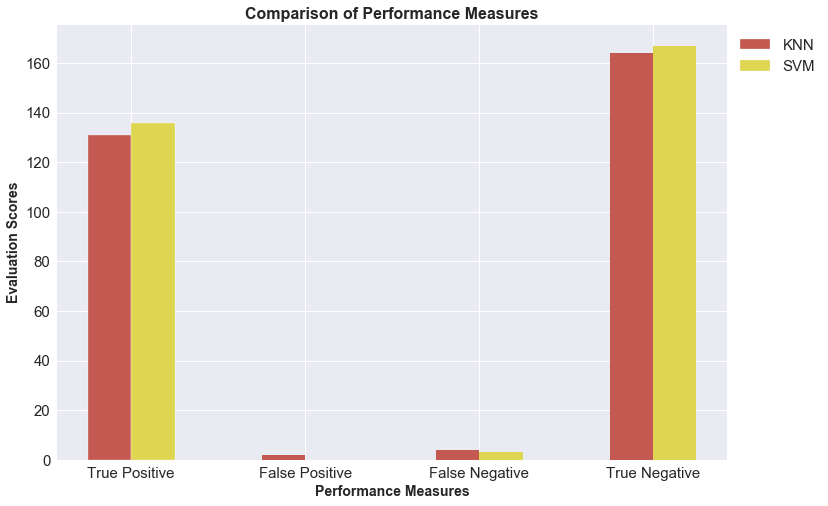

In [644]:
# Setting bar width
bar_width = 0.25

# Setting postions of bars on x-axis
bar_knn = np.arange(len(perf_measure_knn))
bar_svm = [x + bar_width for x in bar_knn]

plt.figure(figsize=(12, 8))

# Plot
plt.title("Comparison of Performance Measures", fontweight='bold', fontsize=16)
plt.bar(bar_knn, perf_measure_knn, color='#C45951', width=bar_width, edgecolor='white', label='KNN')
plt.bar(bar_svm, perf_measure_svm, color='#DED550', width=bar_width, edgecolor='white', label='SVM')

# Add ylabel and xticks
plt.ylabel('Evaluation Scores', fontweight='bold', fontsize=14)
plt.xlabel('Performance Measures', fontweight='bold', fontsize=14)
plt.xticks([i + 0.125 for i in range(len(perf_measure_knn))], ['True Positive', 'False Positive', 'False Negative', 'True Negative'])

plt.legend(bbox_to_anchor=(1, 1), loc=0)
plt.show()

Above bar plot clearly shows that TP and TN are higher for SVM than KNN that means SVM has correctly classified a true calse as true and a false class as false more than KNN. Whereas KNN got higher FP and FN than SVM that means KNN has incorrectly classified a false class as true and a true class as false.

## Conclusion:

We trained two classification models - K-Nearest Neighbours(KNN) and Support Vector Machine(SVM) using pre-processed data and performed several evaluation experiments to verify which model has performed better on this dataset to identify correctly the labels.

With the output of accuracies, cross-validation scores, precision, recall, f1-score and other performance measures, we can conclude the SVM has performed better than KNN and well suited for text classification.

Text categorization tend to have high dimenstional feature space, few irrelevant features and sparse instance vectors.

The experimental result shows that SVM consistently achieved good performance, outperforming KNN model significantly. This is because SVM has the ability to generalize well in high dimensional feature spaces, SVM eliminates the need of feature selection, making the application of text categorization considerably easier. On the other hand, KNN works better in low-dimensional feature space because in high dimensional feature space distance between examples(sparsity) get bigger and thus failed in correctly categorizing the new examples. Also, K-NN has the issue of finding the right value of 'k' and needs performance tuning which allows the model to take more time to build.